In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
aapl = pd.read_csv('csv/AAPL_CLOSE', index_col='Date', parse_dates=True)
cisco = pd.read_csv('csv/CISCO_CLOSE', index_col='Date', parse_dates=True)
ibm = pd.read_csv('csv/IBM_CLOSE', index_col='Date', parse_dates=True)
amzn = pd.read_csv('csv/AMZN_CLOSE', index_col='Date', parse_dates=True)

In [3]:
stocks = pd.concat([aapl, cisco, ibm, amzn], axis = 1)
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn']
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [5]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


In [6]:
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

,aapl,cisco,ibm,amzn
Date,,,,
2012-01-03,NaN,NaN,NaN,NaN
2012-01-04,0.005360,0.019139,-0.004088,-0.008526
2012-01-05,0.011041,-0.003693,-0.004754,0.000563
2012-01-06,0.010400,-0.003707,-0.011547,0.027763
2012-01-09,-0.001587,0.006346,-0.005218,-0.022428


In [13]:
np.random.seed(101)

print(stocks.columns)
weights  = np.array(np.random.random(4))

print("Random weights")
print(weights)

print("Rebalance")
weights = weights / np.sum(weights)
print(weights)

# Expected return
print('Expected Portfolio Return')
exp_ret = np.sum((log_ret.mean() * weights) * 252)
print(exp_ret)

# Expected volatility
print("Expected volatility")
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)

# Sharpe Ratio
print("Sharpe Ratio")
SR = exp_ret / exp_vol
print(SR)

Index(['aapl', 'cisco', 'ibm', 'amzn'], dtype='object')
Random weights
[0.51639863 0.57066759 0.02847423 0.17152166]
Rebalance
[0.40122278 0.44338777 0.02212343 0.13326603]
Expected Portfolio Return
0.15599272049632004
Expected volatility
0.18502649565909488
Sharpe Ratio
0.8430831483926032


In [29]:
np.random.seed(101)

num_ports = 20000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    weights = np.array(np.random.random(4))
    weights = weights / np.sum(weights)
    all_weights[ind, :] = weights
    ret_arr[ind] = np.sum((log_ret.mean() * weights)* 252)    
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]


In [30]:
sharpe_arr.max()

1.0303260551271067

In [31]:
sharpe_arr.argmax()

1420

In [26]:
all_weights[1420, :]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

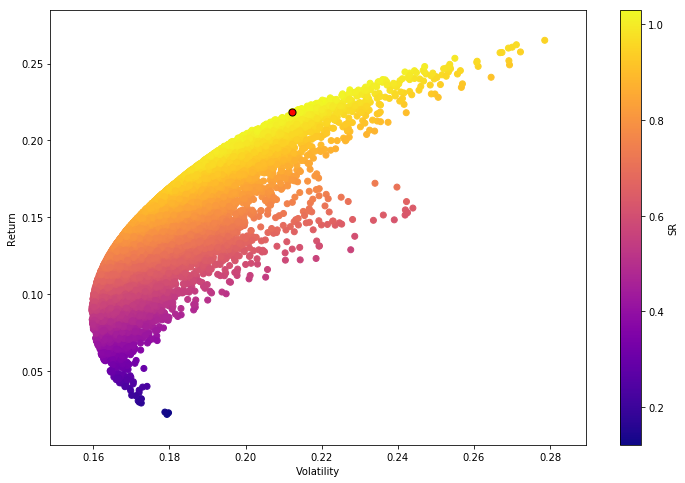

In [34]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='SR')
plt.xlabel('Volatility')
plt.ylabel('Return')

max_sr_ret = ret_arr[sharpe_arr.argmax()]
max_sr_vol = vol_arr[sharpe_arr.argmax()]
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolor='black')

In [39]:
## Mathematical Optimization
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

from scipy.optimize import minimize

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq','fun': check_sum})
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
init_guess = [0.25,0.25,0.25,0.25]

opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)


print(opt_results)
print(opt_results.x)

get_ret_vol_sr(opt_results.x)

     fun: -1.0307168703346545
     jac: array([ 5.64306974e-05,  4.18573618e-05,  3.39921743e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([2.66289765e-01, 2.04189837e-01, 9.23875776e-17, 5.29520398e-01])
[2.66289765e-01 2.04189837e-01 9.23875776e-17 5.29520398e-01]


array([0.21885915, 0.21233683, 1.03071687])

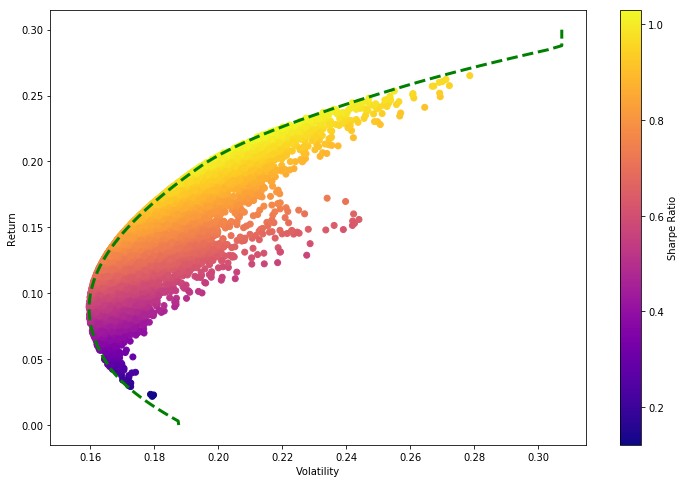

In [42]:
frontier_y = np.linspace(0,0.3,100)

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    frontier_volatility.append(result['fun'])

plt.figure(figsize=(12,8))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)